Students: Kerim Kochekov, Utkarsh Kalra

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_text.zip

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
#from cache import cache

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

We will use the VGG16 model that has been pre-trained for classifying images. But instead of using the last classification layer, we will redirect the output of the previous layer. This gives us a vector with 4096 elements that summarizes the image-contents - similar to how a "thought-vector" summarized the contents of an input-text in Tutorial #21 on language translation. We will use this vector as the initial state of the Gated Recurrent Units (GRU). However, the internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements.

The decoder then uses this initial-state together with a start-marker "ssss" to begin producing output words. In the first iteration it will hopefully output the word "big". Then we input this word into the decoder and hopefully we get the word "brown" out, and so on. Finally we have generated the text "big brown bear sitting eeee" where "eeee" marks the end of the text.

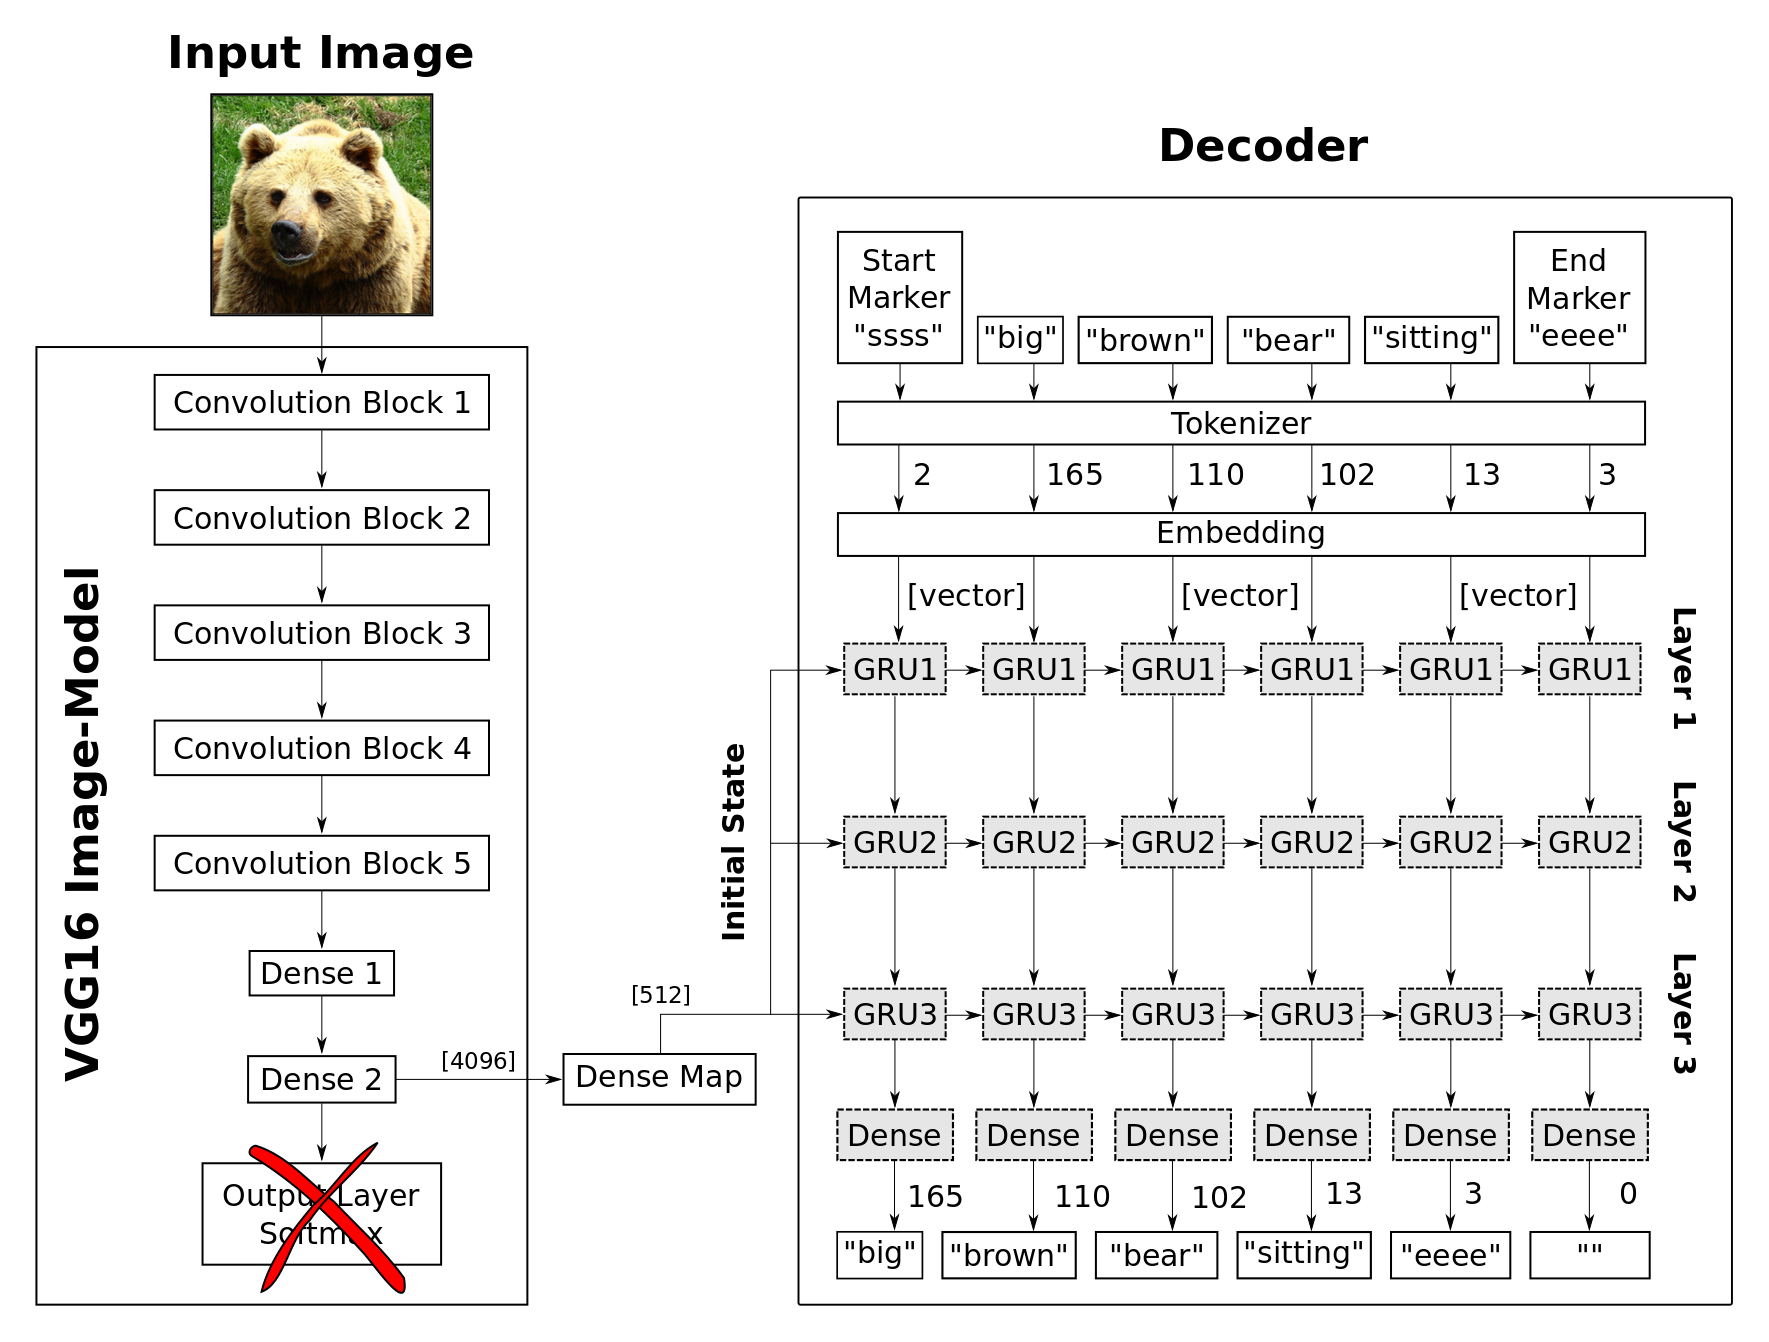

In [ ]:
import os
files = os.listdir("/content/Flicker8k_Dataset") 
captions = []

In [ ]:
file_id = {}
for i in range(len(files)):
    captions.append([])
    file_id[files[i]] = i

In [ ]:
file = open('/content/Flickr8k.token.txt')
lines = file.readlines()
for line in lines:
    word, sentence = line.split("\t")
    pic, index = word.split('#')
    if pic in file_id:
        captions[file_id[pic]].append(sentence[:-3])

In [ ]:
#If we want to split to train validation
#filenames_train, filenames_val, captions_train, captions_val = train_test_split(files, captions, test_size = 0.2)
filenames_train, captions_train = files, captions

In [ ]:
num_images_train = len(filenames_train)

In [ ]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """
    # Load the image using PIL.
    img = Image.open(path)
    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
    # Convert image to numpy array.
    img = np.array(img)
    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """
    dir = ""
    # Use an image from the training-set.
    dir = "/content/Flicker8k_Dataset"

    if train:
        # Use an image from the training-set.
        filename = filenames_train[idx]
        caption = captions_train[idx]
    else:
        # Use an image from the validation-set.
        filename = filenames_val[idx]
        caption = captions_val[idx]
       
    # Path for the image-file.
    path = os.path.join(dir, filename)
    # Print the captions for this image.
    for cap in caption:
        print(cap)
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

A group of brown dogs are standing on a road with 3 people
Dogs and their masters gather on a dirt trail
Several brown dogs of different sizes gather together
There are 5 brown dogs on leashes with their owners nearby
Three women are standing among a group of brown dogs


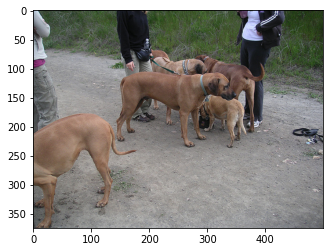

In [ ]:
show_image(100, True)

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 6s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = image_model.get_layer('fc2')
image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
print(img_size)
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print(transfer_values_size)

(224, 224)
4096


In [ ]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def process_images(data_dir, filenames, batch_size = 32):
    num_images = len(filenames)
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)
    start_index = 0

    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)
        end_index = start_index + batch_size
        if end_index > num_images:
            end_index = num_images
        current_batch_size = end_index - start_index
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)
            img = load_image(path, size=img_size)
            image_batch[i] = img

        transfer_values_batch = image_model_transfer.predict(image_batch[0:current_batch_size])
        transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]
        start_index = end_index

    print()
    return transfer_values

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))
    transfer_values = process_images("/content/Flicker8k_Dataset", filenames_train)
    return transfer_values

def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))
    transfer_values = process_images("/content/Flicker8k_Dataset", filenames_val)
    return transfer_values

In [ ]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 8091 images in training-set ...
- Progress: 99.7%
dtype: float16
shape: (8091, 4096)
CPU times: user 2min 44s, sys: 2.37 s, total: 2min 46s
Wall time: 2min 54s


In [ ]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

In [ ]:
mark_start = 'startseq '
mark_end = ' endseq'

In [ ]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end for caption in captions_list] for captions_list in captions_listlist]
    return captions_marked

def flatten(captions_listlist):
    captions_list = [caption for captions_list in captions_listlist for caption in captions_list]
    return captions_list

In [ ]:
captions_train_marked = mark_captions(captions_train)
captions_train_flat = flatten(captions_train_marked)

In [ ]:
class TokenizerWrap(Tokenizer):
    def __init__(self, texts, num_words=None):
        Tokenizer.__init__(self, num_words=num_words)
        self.fit_on_texts(texts)
        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))

    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token] for token in tokens if token != 0]
        text = " ".join(words)
        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list) for captions_list in captions_listlist]
        return tokens

In [ ]:
%%time
num_words = 10000
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words = num_words)

CPU times: user 667 ms, sys: 5.97 ms, total: 673 ms
Wall time: 676 ms


In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
print(mark_start, "id =", token_start)
token_end = tokenizer.word_index[mark_end.strip()]
print(mark_end, "id =", token_end)

startseq  id = 2
 endseq id = 3


In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 736 ms, sys: 60.3 ms, total: 797 ms
Wall time: 793 ms


In [ ]:
def get_random_caption_tokens(idx):
    result = []
    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)

    return result

def batch_generator(batch_size): #Random
    while True:
        idx = np.random.randint(num_images_train, size=batch_size)
        transfer_values = transfer_values_train[idx]
        tokens = get_random_caption_tokens(idx)
        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)
        tokens_padded = pad_sequences(tokens, maxlen=max_tokens, padding='post', truncating='post')
        decoder_input_data = tokens_padded[:, 0: -1]
        decoder_output_data = tokens_padded[:, 1:]
        x_data = {
            'decoder_input': decoder_input_data, #24
            'transfer_values_input': transfer_values #4096
        }
        y_data = {
            'decoder_output': decoder_output_data #24
        }
        yield (x_data, y_data)

In [ ]:
batch_size = 384
generator = batch_generator(batch_size = batch_size)

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
num_captions_train = [len(captions) for captions in captions_train]
total_num_captions_train = np.sum(num_captions_train)
steps_per_epoch = int(total_num_captions_train / batch_size)

In [ ]:
#The decoder consists of 3 GRU layers whose internal state-sizes are
state_size = 512
#The embedding-layer converts integer-tokens into vectors of this length:
embedding_size = 128

transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')
decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)
decoder_dense = Dense(num_words, activation='softmax', name='decoder_output')

In [ ]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)
    model = decoder_input
    model = decoder_embedding(model)
    model = decoder_gru1(model, initial_state=initial_state)
    model = decoder_gru2(model, initial_state=initial_state)
    model = decoder_gru3(model, initial_state=initial_state)
    decoder_output = decoder_dense(model)
    return decoder_output

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)
decoder_model = Model(inputs=[transfer_values_input, decoder_input], outputs=[decoder_output])

In [ ]:
decoder_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy')

In [ ]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
callback_tensorboard = TensorBoard(log_dir='./22_logs/', histogram_freq=0, write_graph=False)
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
%%time
decoder_model.fit(x=generator, steps_per_epoch=steps_per_epoch, epochs=20, callbacks=callbacks)

Epoch 1/20
105/105 [==============================] - 46s 374ms/step - loss: 2.6323

Epoch 00001: saving model to 22_checkpoint.keras
Epoch 2/20
105/105 [==============================] - 39s 369ms/step - loss: 1.9320

Epoch 00002: saving model to 22_checkpoint.keras
Epoch 3/20
105/105 [==============================] - 39s 369ms/step - loss: 1.7088

Epoch 00003: saving model to 22_checkpoint.keras
Epoch 4/20
105/105 [==============================] - 39s 370ms/step - loss: 1.5648

Epoch 00004: saving model to 22_checkpoint.keras
Epoch 5/20
105/105 [==============================] - 39s 369ms/step - loss: 1.4769

Epoch 00005: saving model to 22_checkpoint.keras
Epoch 6/20
105/105 [==============================] - 39s 374ms/step - loss: 1.4024

Epoch 00006: saving model to 22_checkpoint.keras
Epoch 7/20
105/105 [==============================] - 39s 374ms/step - loss: 1.3449

Epoch 00007: saving model to 22_checkpoint.keras
Epoch 8/20
105/105 [==============================] - 39s 372m

In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    output_text = ''
    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1

    output_tokens = decoder_input_data[0]
    plt.imshow(image)
    plt.show()
    print("Predicted caption:")
    print(output_text)

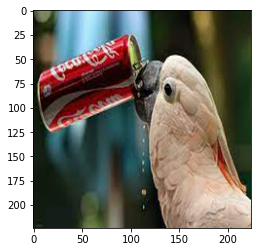

Predicted caption:
 a man with a tattoo on his arm is standing in front of a crowd endseq


In [ ]:
generate_caption("/content/images/1.jpeg")

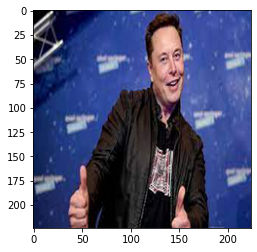

Predicted caption:
 a man in a red shirt is standing in front of a white sign endseq


In [ ]:
generate_caption("/content/images/2.jpeg")